Final Project by Alicia Bergeron and Nick Arangio

Installation instructions, create pip venv, and install all required files using requirements.txt

Once done, ensure you are in the correct env in terminal and type the following:

python -m ipykernel intall --user --name:[env name]

In [123]:
import argparse
import functools
import logging
import os
import math

import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
from collections import Counter

import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions import constraints
from sklearn.feature_extraction.text import CountVectorizer
import tomotopy as tp

import nltk
from nltk.corpus import stopwords

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, JitTraceEnum_ELBO, TraceEnum_ELBO, NUTS, MCMC, TraceMeanField_ELBO
from pyro.optim import Adam

stop = set(stopwords.words('english'))
pyro.set_rng_seed(0)
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

### Dataset Information
Sentiments: sadness, anger, love, surprise, fear, joy

In [124]:
dataset = 'Emotions dataset for NLP/train.txt'

In [125]:
ds = pd.read_csv(dataset, sep=';', header=None)
ds.columns = ["Text", "Sentiment"]
display(ds.head())
display(ds.Sentiment.unique())
display(ds.describe())
display(ds.iloc[3111])

def filter(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in str(text).split() if word not in stop])
df = ds
df.Text = df.Text.apply(lambda t: filter(t))



,Text,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

,Text,Sentiment
count,16000,16000
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5362


Text         in the army
Sentiment          anger
Name: 3111, dtype: object

In [126]:
dfA = df
dfA.Sentiment = dfA.Sentiment.map({
    'sadness':1,
    'anger':2,
    'love':3,
    'surprise':4,
    'fear':5,
    'joy':6
}
)

False

,Text,Sentiment,Length
0,didnt feel humiliated,1,3
1,go feeling hopeless damned hopeful around some...,1,9
2,grabbing minute post feel greedy wrong,2,6
3,ever feeling nostalgic fireplace know still pr...,3,7
4,feeling grouchy,2,2


<Axes: xlabel='Length'>

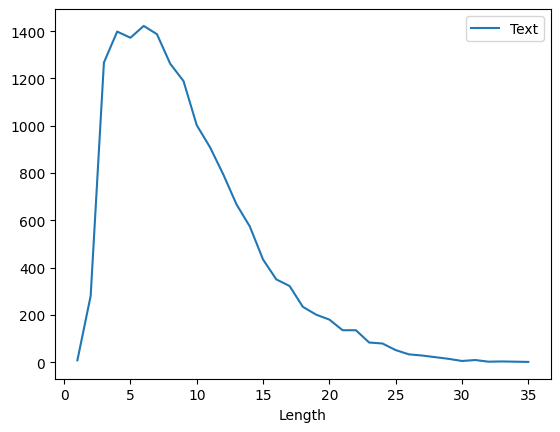

In [127]:
df['Length'] = dfA.Text.str.split("\\s+").apply(lambda a: len(a))
graphing = df.groupby('Length').nunique()
# display(graphing)
display(df['Length'].iloc[0] > 5)
display(df.head())
norm_index = df[(df['Length'] < 5) | (df['Length'] > 20)].index
df_norm = df.drop(norm_index)

graphing.plot(y='Text', use_index=True, kind='line')

In [128]:
df_norm.describe()

,Sentiment,Length
count,12324.000000,12324.000000
mean,3.618468,9.866926
std,2.117923,3.860105
min,1.000000,5.000000
25%,1.000000,7.000000
50%,4.000000,9.000000
75%,6.000000,12.000000
max,6.000000,20.000000


In [129]:
vocab = Counter()
df_norm.Text.str.lower().str.split().apply(vocab.update)
len(list(vocab.keys()))

12188

In [130]:
analysis = {}
for index, row in df_norm.iterrows():
    for w in str(row['Text']).split():
        if w in analysis:
            analysis[w] += row['Sentiment']
        else:
            analysis [w] = row['Sentiment']
# print(analysis)

In [131]:
for key in analysis:
    # print(analysis[key])
    # print(key)
    analysis[key] = [analysis[key] / vocab[key], vocab[key]]


In [132]:
new_analysis = {k: v for k, v in analysis.items() if v[1] <= 300}
outliers = {k: v for k, v in analysis.items() if v[1] > 300}
print(outliers)


{'go': [3.7257617728531858, 361], 'feeling': [3.517281644091546, 4282], 'feel': [3.6459523009741353, 8931], 'know': [3.400259067357513, 772], 'still': [3.4390243902439024, 492], 'ive': [3.3830645161290325, 496], 'time': [3.6404358353510897, 826], 'like': [3.5404658507698383, 2533], 'life': [3.518375241779497, 517], 'make': [3.9251497005988023, 668], 'something': [3.8067415730337077, 445], 'think': [3.622093023255814, 516], 'thing': [3.373263888888889, 576], 'dont': [3.4168618266978923, 427], 'need': [3.6481481481481484, 378], 'get': [3.550147492625369, 678], 'day': [3.6283185840707963, 565], 'pretty': [3.9714285714285715, 315], 'much': [3.5754060324825985, 431], 'would': [3.4456521739130435, 552], 'want': [3.511864406779661, 590], 'bit': [3.2685851318944845, 417], 'way': [3.511879049676026, 463], 'one': [3.5644283121597096, 551], 'could': [3.5800970873786406, 412], 'people': [3.6236933797909407, 574], 'back': [3.4226190476190474, 336], 'love': [3.844943820224719, 445], 'see': [3.671009

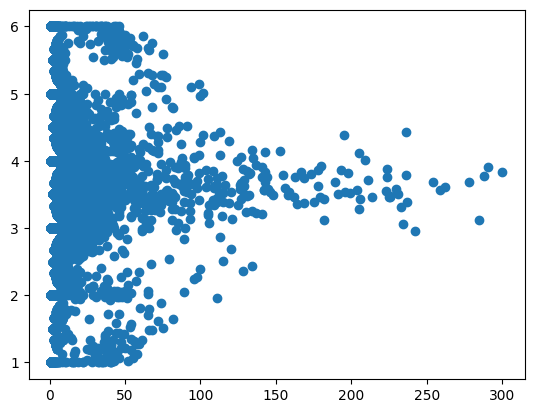

In [133]:
txt = new_analysis.keys
values = list(new_analysis.values())
fig, ax = plt.subplots()
ax.scatter([item[1] for item in values], [item[0] for item in values])


In [183]:
df_sad = df_norm[df_norm["Sentiment"] == 1]
# display(df_sad)
df_sad = df_sad.groupby(df_sad.index // 7)['Text'].apply(' '.join)

df_anger = df_norm[df_norm["Sentiment"] == 2]
# display(df_anger)
df_anger = df_anger.groupby(df_anger.index // 7)['Text'].apply(' '.join)

df_love = df_norm[df_norm["Sentiment"] == 3]
# display(df_love)
df_love = df_love.groupby(df_love.index // 7)['Text'].apply(' '.join)

df_surprise = df_norm[df_norm["Sentiment"] == 4]
# display(df_surprise)
df_surprise = df_surprise.groupby(df_surprise.index // 7)['Text'].apply(' '.join)

df_fear = df_norm[df_norm["Sentiment"] == 5]
# display(df_fear)
df_fear = df_fear.groupby(df_fear.index // 7)['Text'].apply(' '.join)

df_joy = df_norm[df_norm["Sentiment"] == 6]
# display(df_joy)
df_joy = df_joy.groupby(df_joy.index // 7)['Text'].apply(' '.join)

df_concat = pd.concat([df_sad, df_anger, df_love, df_surprise, df_fear, df_joy], axis=0)


df_random = df_norm.groupby(df_norm.index // 7)['Text'].apply(' '.join)

display(df_norm)
display(df_concat)
display(df_random)

,Text,Sentiment,Length
1,go feeling hopeless damned hopeful around some...,1,9
2,grabbing minute post feel greedy wrong,2,6
3,ever feeling nostalgic fireplace know still pr...,3,7
5,ive feeling burdened lately wasnt sure,1,6
6,ive taking milligram time recommended amount i...,4,15
...,...,...,...
15993,day feel like braeden calvin happy successful day,6,8
15995,brief time beanbag said anna feel like beaten,1,8
15996,turning feel pathetic still waiting table subb...,1,9
15998,feel like rude comment glad,2,5


0       go feeling hopeless damned hopeful around some...
1          feel like make suffering seeing mean something
2       started feeling sentimental doll child began c...
3       feel inhibited someone el kitchen like paintin...
6       feeling discouraged already robbing peter pay ...
                              ...                        
2279    feeling inspired get work done feeling like ci...
2280    sure parent feeling grandparent manchester one...
2282         need work better nutrition time feel amazing
2283    dont even know going write wine flowing dining...
2284    feel really glad dont look like celebrity beau...
Name: Text, Length: 7495, dtype: object

0       go feeling hopeless damned hopeful around some...
1       feel confused life teenager jaded year old man...
2       started feeling sentimental doll child began c...
3       feeling completely overwhelmed two strategy he...
4       feel kinda appalled feel like need explain wid...
                              ...                        
2281    feeling bit discouraged word really hit home f...
2282    feeling much like guy pic overwhelmed starved ...
2283    dont even know going write wine flowing dining...
2284    feel really glad dont look like celebrity beau...
2285    brief time beanbag said anna feel like beaten ...
Name: Text, Length: 2286, dtype: object

In [160]:
vectorizer = CountVectorizer(stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(df_norm['Text']).toarray())

In [189]:
hdp = tp.HDPModel(min_cf=3, rm_top=10, gamma=1, alpha=0.1, initial_k = 3, seed=0)

# for doc in list(df_random):
#     hdp.add_doc(doc.split())

for doc in list(df_concat):
    hdp.add_doc(doc.split())

hdp.burn_in = 100
hdp.train(0)
for i in tqdm(range(0, 10000, 100)):
    hdp.train(100)
    print(f'i: {i}, log_probs: {hdp.ll_per_word}, topics: {hdp.live_k}')
    n_topics = hdp.live_k

/var/folders/d5/d4vbmxhd4wxdb9smqpxs6x500000gn/T/ipykernel_33179/142465985.py:10: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/d5/d4vbmxhd4wxdb9smqpxs6x500000gn/T/ipykernel_33179/142465985.py:12: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(100)
  2%|▏         | 2/100 [00:02<01:44,  1.07s/it]

i: 0, log_probs: -7.83463327338396, topics: 60
i: 100, log_probs: -7.794624264047455, topics: 52


  3%|▎         | 3/100 [00:03<01:47,  1.11s/it]

i: 200, log_probs: -7.763244932443928, topics: 42
i: 300, log_probs: -7.762697566283178, topics: 40


  5%|▌         | 5/100 [00:05<01:48,  1.14s/it]

i: 400, log_probs: -7.760789900536639, topics: 36
i: 500, log_probs: -7.76061154978513, topics: 43


  7%|▋         | 7/100 [00:08<01:55,  1.24s/it]

i: 600, log_probs: -7.761819734196617, topics: 43
i: 700, log_probs: -7.762375655551211, topics: 47


  9%|▉         | 9/100 [00:10<01:51,  1.23s/it]

i: 800, log_probs: -7.760923347927141, topics: 36
i: 900, log_probs: -7.760602786780145, topics: 42


 11%|█         | 11/100 [00:13<01:47,  1.21s/it]

i: 1000, log_probs: -7.760730477944529, topics: 41
i: 1100, log_probs: -7.7603903105413545, topics: 41


 13%|█▎        | 13/100 [00:15<01:46,  1.22s/it]

i: 1200, log_probs: -7.761054846395298, topics: 43
i: 1300, log_probs: -7.761855731685742, topics: 39


 15%|█▌        | 15/100 [00:18<01:48,  1.27s/it]

i: 1400, log_probs: -7.761458506472573, topics: 49
i: 1500, log_probs: -7.761499742358927, topics: 45


 17%|█▋        | 17/100 [00:20<01:44,  1.26s/it]

i: 1600, log_probs: -7.762502908082929, topics: 40


 18%|█▊        | 18/100 [00:21<01:42,  1.25s/it]

i: 1700, log_probs: -7.760630281015162, topics: 39
i: 1800, log_probs: -7.761211506750638, topics: 41


 20%|██        | 20/100 [00:24<01:39,  1.25s/it]

i: 1900, log_probs: -7.761142315829175, topics: 40
i: 2000, log_probs: -7.761091549042942, topics: 43


 22%|██▏       | 22/100 [00:26<01:37,  1.25s/it]

i: 2100, log_probs: -7.760708424058937, topics: 43
i: 2200, log_probs: -7.76104141663292, topics: 44


 24%|██▍       | 24/100 [00:29<01:35,  1.26s/it]

i: 2300, log_probs: -7.761547010731711, topics: 47
i: 2400, log_probs: -7.761086386999893, topics: 41


 26%|██▌       | 26/100 [00:31<01:33,  1.26s/it]

i: 2500, log_probs: -7.761578105148342, topics: 44
i: 2600, log_probs: -7.762036497788972, topics: 44


 28%|██▊       | 28/100 [00:34<01:29,  1.25s/it]

i: 2700, log_probs: -7.76127128706196, topics: 43
i: 2800, log_probs: -7.760776184513292, topics: 41


 30%|███       | 30/100 [00:36<01:27,  1.25s/it]

i: 2900, log_probs: -7.762085441441392, topics: 41
i: 3000, log_probs: -7.7611454923921555, topics: 41


 32%|███▏      | 32/100 [00:39<01:25,  1.25s/it]

i: 3100, log_probs: -7.760958560821424, topics: 40
i: 3200, log_probs: -7.761618134034766, topics: 42


 34%|███▍      | 34/100 [00:42<01:24,  1.28s/it]

i: 3300, log_probs: -7.761865888023351, topics: 40
i: 3400, log_probs: -7.76097958225926, topics: 38


 36%|███▌      | 36/100 [00:44<01:19,  1.25s/it]

i: 3500, log_probs: -7.761868731699128, topics: 40
i: 3600, log_probs: -7.761863382746624, topics: 38


 38%|███▊      | 38/100 [00:46<01:16,  1.24s/it]

i: 3700, log_probs: -7.761211699868747, topics: 47
i: 3800, log_probs: -7.761087040811095, topics: 46


 40%|████      | 40/100 [00:49<01:13,  1.23s/it]

i: 3900, log_probs: -7.761589270662346, topics: 38
i: 4000, log_probs: -7.7607901350457755, topics: 42


 42%|████▏     | 42/100 [00:51<01:14,  1.28s/it]

i: 4100, log_probs: -7.761767402782588, topics: 47


 43%|████▎     | 43/100 [00:53<01:12,  1.26s/it]

i: 4200, log_probs: -7.762249569246912, topics: 46
i: 4300, log_probs: -7.761206308682259, topics: 40


 45%|████▌     | 45/100 [00:55<01:08,  1.24s/it]

i: 4400, log_probs: -7.761985485798747, topics: 47
i: 4500, log_probs: -7.76220655651632, topics: 44


 47%|████▋     | 47/100 [00:58<01:05,  1.23s/it]

i: 4600, log_probs: -7.7617032771285075, topics: 42
i: 4700, log_probs: -7.7605328224284555, topics: 42


 49%|████▉     | 49/100 [01:00<01:03,  1.25s/it]

i: 4800, log_probs: -7.759935641587315, topics: 41
i: 4900, log_probs: -7.7618477828104195, topics: 42


 51%|█████     | 51/100 [01:03<01:03,  1.29s/it]

i: 5000, log_probs: -7.761059427382446, topics: 44
i: 5100, log_probs: -7.761005972348181, topics: 40


 53%|█████▎    | 53/100 [01:05<00:58,  1.25s/it]

i: 5200, log_probs: -7.759889729825016, topics: 38
i: 5300, log_probs: -7.762104591644658, topics: 39


 55%|█████▌    | 55/100 [01:08<00:55,  1.24s/it]

i: 5400, log_probs: -7.761218944141434, topics: 42
i: 5500, log_probs: -7.760649110722435, topics: 39


 57%|█████▋    | 57/100 [01:10<00:53,  1.24s/it]

i: 5600, log_probs: -7.761143602735185, topics: 40
i: 5700, log_probs: -7.761104384288202, topics: 40


 59%|█████▉    | 59/100 [01:13<00:50,  1.23s/it]

i: 5800, log_probs: -7.760879883454985, topics: 39
i: 5900, log_probs: -7.761296336512217, topics: 42


 61%|██████    | 61/100 [01:15<00:48,  1.24s/it]

i: 6000, log_probs: -7.7610372865704775, topics: 42
i: 6100, log_probs: -7.7605575179593345, topics: 41


 63%|██████▎   | 63/100 [01:18<00:45,  1.23s/it]

i: 6200, log_probs: -7.760866500010888, topics: 41
i: 6300, log_probs: -7.760714594863426, topics: 44


 65%|██████▌   | 65/100 [01:20<00:43,  1.23s/it]

i: 6400, log_probs: -7.759913574929485, topics: 48
i: 6500, log_probs: -7.7609671838407035, topics: 41


 67%|██████▋   | 67/100 [01:22<00:40,  1.24s/it]

i: 6600, log_probs: -7.760709070113887, topics: 40
i: 6700, log_probs: -7.76021766357254, topics: 37


 69%|██████▉   | 69/100 [01:25<00:39,  1.27s/it]

i: 6800, log_probs: -7.762001982325665, topics: 43
i: 6900, log_probs: -7.75937925640529, topics: 37


 71%|███████   | 71/100 [01:27<00:35,  1.23s/it]

i: 7000, log_probs: -7.7603924751041635, topics: 42
i: 7100, log_probs: -7.760840842323924, topics: 40


 73%|███████▎  | 73/100 [01:30<00:33,  1.24s/it]

i: 7200, log_probs: -7.760385928528651, topics: 37
i: 7300, log_probs: -7.761330194247051, topics: 46


 75%|███████▌  | 75/100 [01:32<00:30,  1.23s/it]

i: 7400, log_probs: -7.760554581576531, topics: 42
i: 7500, log_probs: -7.760860811988622, topics: 41


 77%|███████▋  | 77/100 [01:35<00:30,  1.30s/it]

i: 7600, log_probs: -7.7606256273379595, topics: 38
i: 7700, log_probs: -7.760467919706124, topics: 39


 79%|███████▉  | 79/100 [01:38<00:26,  1.28s/it]

i: 7800, log_probs: -7.7604973094153, topics: 41
i: 7900, log_probs: -7.761494309392554, topics: 45


 81%|████████  | 81/100 [01:40<00:23,  1.24s/it]

i: 8000, log_probs: -7.761321161808924, topics: 40
i: 8100, log_probs: -7.760258555276584, topics: 43


 83%|████████▎ | 83/100 [01:42<00:20,  1.21s/it]

i: 8200, log_probs: -7.7610890305816325, topics: 40
i: 8300, log_probs: -7.7606394426110406, topics: 38


 85%|████████▌ | 85/100 [01:45<00:17,  1.19s/it]

i: 8400, log_probs: -7.760944825809355, topics: 41
i: 8500, log_probs: -7.760581639298019, topics: 40


 87%|████████▋ | 87/100 [01:47<00:16,  1.25s/it]

i: 8600, log_probs: -7.7609376974550335, topics: 43
i: 8700, log_probs: -7.76136795566464, topics: 38


 89%|████████▉ | 89/100 [01:50<00:13,  1.24s/it]

i: 8800, log_probs: -7.760668578182964, topics: 38
i: 8900, log_probs: -7.7612360430200145, topics: 45


 91%|█████████ | 91/100 [01:52<00:11,  1.24s/it]

i: 9000, log_probs: -7.760519448215132, topics: 38
i: 9100, log_probs: -7.7604619376040045, topics: 39


 93%|█████████▎| 93/100 [01:55<00:08,  1.24s/it]

i: 9200, log_probs: -7.760000112600713, topics: 35
i: 9300, log_probs: -7.760636118982035, topics: 43


 96%|█████████▌| 96/100 [01:59<00:05,  1.28s/it]

i: 9400, log_probs: -7.759631434293463, topics: 37
i: 9500, log_probs: -7.760744033691172, topics: 37


 98%|█████████▊| 98/100 [02:01<00:02,  1.25s/it]

i: 9600, log_probs: -7.759418444813767, topics: 36
i: 9700, log_probs: -7.760530706905923, topics: 40


 99%|█████████▉| 99/100 [02:02<00:01,  1.24s/it]

i: 9800, log_probs: -7.76253064658764, topics: 42
i: 9900, log_probs: -7.760380177271544, topics: 41


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


In [190]:
sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

topics={}

# For topics found, extract only those that are still assigned
for k in sorted_topics:
    if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
    topic_wp =[]
    for word, prob in hdp.get_topic_words(k, top_n=6):
        topic_wp.append((word, prob))

    topics[k] = topic_wp # store topic word/frequency array
# print(hdp.removed_top_words)
topics


{2: [('would', 0.006268275901675224),
  ('people', 0.006145850755274296),
  ('day', 0.006145850755274296),
  ('one', 0.005913243629038334),
  ('life', 0.005803061183542013),
  ('think', 0.005680636502802372)],
 1: [('ive', 0.008102759718894958),
  ('one', 0.008102759718894958),
  ('people', 0.007871318608522415),
  ('day', 0.0076398770324885845),
  ('think', 0.0060197883285582066),
  ('dont', 0.0060197883285582066)],
 0: [('dont', 0.010355579666793346),
  ('bit', 0.008876563049852848),
  ('people', 0.008630060590803623),
  ('still', 0.008383558131754398),
  ('one', 0.007151044439524412),
  ('love', 0.006658039055764675)],
 7: [('love', 0.05619238689541817),
  ('naughty', 0.0481763556599617),
  ('never', 0.040160320699214935),
  ('sweet', 0.024128256365656853),
  ('smell', 0.024128256365656853),
  ('cute', 0.016112225130200386)],
 4: [('unnatural', 0.026696231216192245),
  ('racism', 0.017827050760388374),
  ('song', 0.017827050760388374),
  ('punished', 0.017827050760388374),
  ('yeah'

In [ ]:
# def mix_weights(beta):
#     beta1m_cumprod = (1 - beta).cumprod(-1)
#     print(beta1m_cumprod)
#     return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

# def model(data):
#     alpha = 0.1
#     T = 5
#     N = 30

#     # T-1 conditionally independent Beta distributions of B
#     with pyro.plate("beta_plate", T-1): 
#         beta = pyro.sample("beta", dist.Beta(1, alpha)) 

#     # T conditionally independent priors
#     with pyro.plate("mu_plate", T):
#         mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

#     # N conditionally independent Categorical distributions for cluster assignment
#     with pyro.plate("data", N):
#         z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
#         pyro.sample("obs", dist.MultivariateNormal(mu[z], torch.eye(2)), obs=data)

# model([1,1,1])

In [ ]:
# def guide(data):
#     kappa = pyro.param('kappa', lambda: dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
#     tau = pyro.param('tau', lambda: dist.MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
#     phi = pyro.param('phi', lambda: dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

#     with pyro.plate("beta_plate", T-1):
#         q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

#     with pyro.plate("mu_plate", T):
#         q_mu = pyro.sample("mu", dist.MultivariateNormal(tau, torch.eye(2)))

#     with pyro.plate("data", N):
#         z = pyro.sample("z", dist.Categorical(phi))

In [ ]:
# T = 10

# def train(num_iterations):
#     pyro.clear_param_store()
#     for j in tqdm(range(num_iterations)):
#         loss = svi.step(data)
#         losses.append(loss)

# def truncate(alpha, centers, weights):
#     threshold = alpha**-1 / 100.
#     true_centers = centers[weights > threshold]
#     true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
#     return true_centers, true_weights

# alpha = 0.1
# train(1000)

# # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

# alpha = 1.5
# train(1000)

# # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# plt.scatter(data[:, 0], data[:, 1], color="blue")
# plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

# plt.subplot(1, 2, 2)
# plt.scatter(data[:, 0], data[:, 1], color="blue")
# plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
# plt.tight_layout()
# plt.show()


In [ ]:
# data = torch.tensor([5, 4, 2, 5, 6, 5, 3, 3, 1, 5, 5, 3, 5, 3, 5, \
#                      3, 5, 5, 3, 5, 5, 3, 1, 5, 3, 3, 6, 5, 5, 6])
# counts = torch.unique(data, return_counts=True)[1].float()
# counts.sum()


In [ ]:

# def model(counts):
#     theta = pyro.sample('theta', dist.Dirichlet(torch.ones(6)))
#     total_count = int(counts.sum())
#     pyro.sample('counts', dist.Multinomial(total_count, theta), obs=counts)

# data = torch.tensor([5, 4, 2, 5, 6, 5, 3, 3, 1, 5, 5, 3, 5, 3, 5, \
#                      3, 5, 5, 3, 5, 5, 3, 1, 5, 3, 3, 6, 5, 5, 6])
# counts = torch.unique(data, return_counts=True)[1].float()

# nuts_kernel = NUTS(model)
# num_samples, warmup_steps = (1000, 200)
# mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
# mcmc.run(counts)
# hmc_samples = {k: v.detach().cpu().numpy()
#                for k, v in mcmc.get_samples().items()}

In [ ]:
# means = hmc_samples['theta'].mean(axis=0)
# stds = hmc_samples['theta'].std(axis=0)
# print('Inferred dice probabilities from the data (68% confidence intervals):')
# for i in range(6):
#     print('%d: %.2f ± %.2f' % (i + 1, means[i], stds[i]))

In [ ]:
# def model(data):
#     with pyro.plate("topics", T):
#         topic_weights = pyro.sample(
#             "topic_weights", dist.Gamma(1.0 / T, 1.0)
#         )
#         topic_words = pyro.sample(
#             "topic_words", dist.Dirichlet(torch.ones(N) / N)
#         )

#     with pyro.plate("documents", data.shape[0]) as ind:
#         doc_topics = pyro.sample("doc_topics", dist.Dirichlet(topic_weights))
#         with pyro.plate("words", max_words):
#             word_topics = pyro.sample(
#                 "word_topics",
#                 dist.Categorical(doc_topics),
#                 infer={"enumerate": "parallel"},
#                 )
#             data = pyro.sample("doc_words", dist.Categorical(topic_words[word_topics]), obs=data)
#     return topic_weights, topic_words, data


# T = 20
# N = len(list(vocab.keys()))
# max_words = 12
# optim = Adam({"lr": 0.05})
# svi = SVI(model, guide, optim, loss=Trace_ELBO())
# losses = []


In [ ]:
# def model(docs):
#     with pyro.plate("beta", docs.size()[0]):
        
#     theta = pyro.sample('theta', dist.Dirichlet(torch.ones[1,T]))
#     with pyro.plate("data", words):
#         z = pyro.sample('obs', dist.Multinomial(words, theta), obs=words)

# nuts_kernel = NUTS(model)
# mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
# T = 6
# mcmc.run(docs)


# hmc_samples = {k: v.detach().cpu().numpy()
#                for k, v in mcmc.get_samples().items()}